- Your script should be able to be run from the command line
- It should take any __weighted edgelist__ as an input, providing that edgelist is saved as a CSV with the column headers "nodeA", "nodeB"
- For any given weighted edgelist given as an input, your script should be used to create a network visualization, which will be saved in a folder called __viz__.
- It should also create a data frame showing the degree, betweenness, and eigenvector centrality for each node. It should save this as a CSV in a folder called __output__.

__Tips__
- You should use __argparse()__ in the Python standard library
- Your code should contain a __main()__ function
- Don't worry too much about efficiency - networkx is really slow, there's no way around i!
- If you have issues with __pygraphviz__, just use the built-in matplotlib functions in networkx.
- You may want to create an argument for the user to define a cut-off point to filter data. E.g. only include node pairs with more than a certain edge weight.
- Make sure to use all of the Python scripting skills you've learned so far, including in the workshops with Kristoffer Nielbo

__Bonus challenges__
- Attempt to implement coreference resolution on entities (time-consuming)
- Bundle your code up into a Python class, focusing on code modularity
- Let the user define which graphing algorithm they use (pretty tricky)
- Are there other ways of creating networks, rather than just document co-occurrence? (really tricky)

In [2]:
import os
import pandas as pd
from collections import Counter
from itertools import combinations
from tqdm import tqdm

import spacy
nlp = spacy.load("en_core_web_sm")

import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

# Create network - not part of assignment

## Define input file and read data to dataframe

In [4]:
input_file = os.path.join("..", "data", "fake_or_real_news.csv")
data = pd.read_csv(input_file)

## Extract all named individuals

We use ```spaCy``` to extract only mentions of PERSONS in the texts.

NB: See final comment below under ```Problems```!

In [5]:
real_df = data[data["label"]=="REAL"]["text"]

In [7]:
text_entities = []

for text in tqdm(real_df):
    # create temporary list 
    tmp_entities = []
    # create doc object
    doc = nlp(text)
    # for every named entity
    for entity in doc.ents:
        # if that entity is a person
        if entity.label_ == "PERSON":
            # append to temp list
            tmp_entities.append(entity.text)
    # append temp list to main list
    text_entities.append(tmp_entities)

100%|██████████| 3171/3171 [08:06<00:00,  6.51it/s]


## Create edgelist using ```itertools.combinations()```

In [9]:
edgelist = []
# iterate over every document
for text in text_entities:
    # use itertools.combinations() to create edgelist
    edges = list(combinations(text, 2))
    # for each combination - i.e. each pair of 'nodes'
    for edge in edges:
        # append this to final edgelist
        edgelist.append(tuple(sorted(edge)))

In [17]:
import csv

with open('edgelist.csv', 'w', encoding='utf-8') as fh_out:
    fh_out.write('nodeA,nodeB\n')

with open('edgelist.csv', 'a', encoding='utf-8') as fh_out:
    writer = csv.writer(fh_out)
    writer.writerows(edgelist)

# Assignment

In [38]:
edgelistpath = 'edgelist.csv'
min_weight = 1000 # default to 0

In [39]:
import csv
from collections import Counter
import os
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
import networkx as nx

In [40]:
# Load edgelist csv as a list of tuples
with open(edgelistpath, newline='') as fh_in:
    reader = csv.reader(fh_in)
    edgelist = [tuple(row) for row in reader]

# Remove headers if these are present
if edgelist[0] == ('nodeA', 'nodeB'):
    edgelist = edgelist[1:]

In [41]:
# Sum up how many times every unique combination of edges occur
# and set this number as the weight of the unique edge
weighted_edges = []

for key, value in Counter(edgelist).items():
    nodeA = key[0]
    nodeB = key[1]
    weight = value
    weighted_edges.append((nodeA, nodeB, weight))

In [42]:
edges_df = pd.DataFrame(weighted_edges, columns=["nodeA", "nodeB", "weight"])

In [43]:
weight_filtered_df = edges_df[edges_df["weight"] > min_weight]

In [44]:
graph = nx.from_pandas_edgelist(weight_filtered_df, 'nodeA', 'nodeB', ["weight"])

In [45]:
graph_positions = nx.nx_agraph.graphviz_layout(graph, prog="neato")

In [46]:
# Create viz folder if it does not already exist
if not os.path.exists('viz'):
    os.makedirs('viz')

graph_outpath = os.path.join('viz', 'network.png')

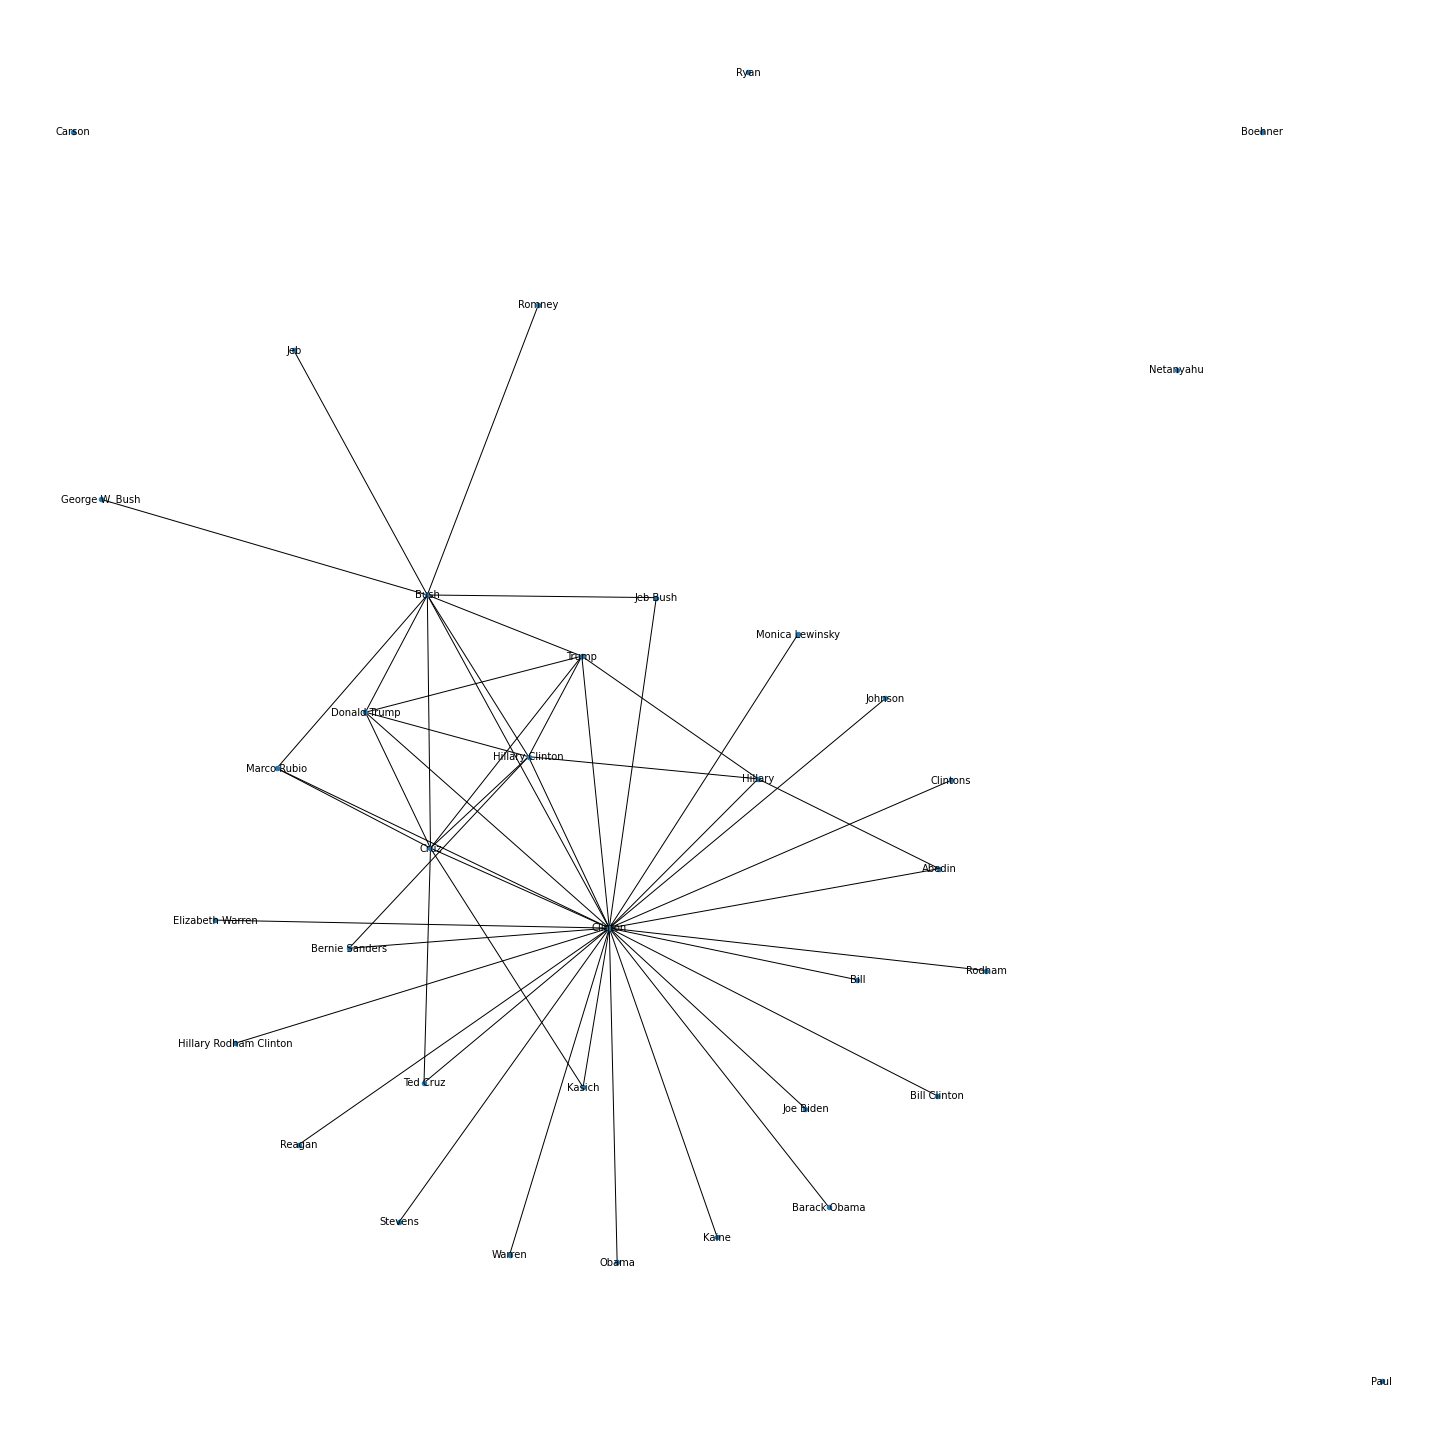

In [47]:
nx.draw(graph, graph_positions, with_labels=True, node_size=20, font_size=10)
plt.savefig(graph_outpath, dpi=300, bbox_inches="tight")

In [82]:
# Calculate centrality measures
ev = nx.eigenvector_centrality(graph)
bc = nx.betweenness_centrality(graph)
dg = graph.degree

ev_df = pd.DataFrame(data = ev.items(), columns = ('node', 'eigenvector_centrality'))
bc_df = pd.DataFrame(data = bc.items(), columns = ('node', 'betweenness_centrality'))
dg_df = pd.DataFrame(data = dg, columns = ('node', 'degree'))

measures_df = ev_df.join(bc_df.set_index('node'), on = 'node').join(dg_df.set_index('node'), on = 'node')

In [84]:
# Create output folder if it does not already exist
if not os.path.exists('output'):
    os.makedirs('output')

measures_outpath = os.path.join('output', 'measures.csv')

measures_df.to_csv(measures_outpath, index = False)